In [1]:
import sys
sys.path.append('/home/onizhuk/codes_development/pyCCE')
sys.path.append('/home/onizhuk/midway/codes_development/pyCCE')
sys.path.append('/home/onizhuk/midway/codes_development/us')

sys.path.append('Z:/codes_development/pyCCE')

import pycce as pc
import numpy as np
import matplotlib.pyplot as plt
import ase
import ase.build
import ase.io

import scipy.optimize
sys.path.append('Z:/codes_development/us')
from dmscripts import *


# Examples of using pyCCE code

## NV Center in diamond

In [2]:
np.random.seed(231)
# From ASE builder
ase_diamond = ase.build.bulk('C', 'diamond', cubic=True)
# Generate NSpinCell
diamond = pc.bath.BathCell.from_ase(ase_diamond)
diamond.add_isotopes(('13C', 0.011))

v_coord = np.array([0., 0., 0.])
n_coord = np.array([0.25, 0.25, 0.25])
print(diamond.atoms)
diamond.zdir = (1, 1, 1)
diamond_bath = diamond.gen_supercell(200, remove=[('C', v_coord), ('C', n_coord)], add=('14N', n_coord))

{'C': [array([0., 0., 0.]), array([0.25, 0.25, 0.25]), array([0. , 0.5, 0.5]), array([0.25, 0.75, 0.75]), array([0.5, 0. , 0.5]), array([0.75, 0.25, 0.75]), array([0.5, 0.5, 0. ]), array([0.75, 0.75, 0.25])]}


In [6]:
print(diamond_bath['14N'])

[('14N', [-1.11022302e-16,  0.00000000e+00,  1.54585535e+00], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])]


In [10]:
r_bath = 40
r_dipole = 8
order = 2

N = 1
timespace = np.linspace(0, 0.5, 101)
B = np.array([0, 0, 0])

L = 0
for i in range(50):
    diamond_bath = diamond.gen_supercell(200, remove=[('C', v_coord), ('C', n_coord)], add=('14N', n_coord))
    calc = pc.Simulator(1, v_coord, [0,0,1], [0,1,0], bath=diamond_bath, 
                        r_bath=r_bath, r_dipole=r_dipole, order=order)
    L += calc.compute_coherence(timespace, B, N)
L /= (i+1)

Adding: 
 ('14N', [-1.11022302e-16,  0.00000000e+00,  1.54585535e+00])
Average number of neighbours is 3.5
Number of disjointed clusters is 27
Adding: 
 ('14N', [-1.11022302e-16,  0.00000000e+00,  1.54585535e+00])
Average number of neighbours is 3.9
Number of disjointed clusters is 24
Adding: 
 ('14N', [-1.11022302e-16,  0.00000000e+00,  1.54585535e+00])
Average number of neighbours is 3.7
Number of disjointed clusters is 37
I see 1 removals
Removing: 
 [('13C', [0., 0., 0.])]
Adding: 
 ('14N', [-1.11022302e-16,  0.00000000e+00,  1.54585535e+00])
Average number of neighbours is 3.7
Number of disjointed clusters is 25
Adding: 
 ('14N', [-1.11022302e-16,  0.00000000e+00,  1.54585535e+00])
Average number of neighbours is 3.4
Number of disjointed clusters is 34
Adding: 
 ('14N', [-1.11022302e-16,  0.00000000e+00,  1.54585535e+00])
Average number of neighbours is 3.7
Number of disjointed clusters is 28
Adding: 
 ('14N', [-1.11022302e-16,  0.00000000e+00,  1.54585535e+00])
Average number of 

[0.13447679 2.5444017 ]


/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


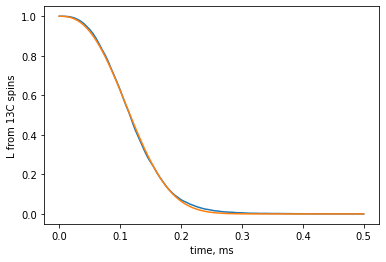

In [14]:
plt.plot(timespace, L)
l, p = newt2_fit(timespace[L.real <= 1.1], L.real[L.real <= 1.1], p0=[0.1, 1], r=6)
plt.plot(timespace[L.real <= 1.1], l(timespace[L.real <= 1.1], *p))
plt.xlabel('time, ms')
plt.ylabel('L from 13C spins')
print(p)

# Conventional CCE

In [102]:
L = calc.compute_coherence(timespace, B, N)

[0.88116 1.9879 ]


/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/onizhuk/codes_development/useful_scripts/dmscripts.py:179: RuntimeWarning: invalid value encountered in power
  return np.exp(-(t / t2) ** n) * y[0]


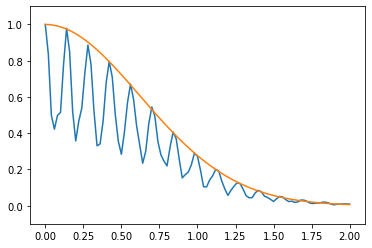

In [111]:
import scipy.optimize
plt.plot(timespace[L.real <= 1.1], L[L.real <= 1.1])
plt.ylim(-0.1, 1.1)
l, p = newt2_fit(timespace[L.real <= 1.1], L.real[L.real <= 1.1], r=6)
plt.plot(timespace[L.real <= 1.1], l(timespace[L.real <= 1.1], *p))
print(p)

# Different materials

In [30]:
si_ase = ase.io.read('si.cif')
si = pc.bath.BathCell.from_ase(si_ase)
si.add_isotopes(('29Si', 0.047))
si.zdir = [1, 1, 1]
vc_uc = [0.5, 0.5, 0.5]
vc = si.to_cartesian(vc_uc)
atoms = si.gen_supercell(200, remove=('Si', vc_uc))
atoms['xyz'] -= vc

In [5]:
volume = si.cell[:, 0].dot(np.cross(si.cell[:, 1], si.cell[:, 2]))
print(volume)
print(np.linalg.det(si.cell))
print(si.atoms)
print(si.cell)
print(si.atoms['Si'].__len__()/volume)

163.5531713946593
163.55317139465942
{'Si': [array([0.25, 0.75, 0.25]), array([0. , 0. , 0.5]), array([0.25, 0.25, 0.75]), array([0. , 0.5, 0. ]), array([0.75, 0.75, 0.75]), array([0.5, 0. , 0. ]), array([0.75, 0.25, 0.25]), array([0.5, 0.5, 0.5])]}
[[ 4.31304979 -1.15567821 -3.15737158]
 [-1.15567821  4.31304979 -3.15737158]
 [ 3.15737158  3.15737158  3.15737158]]
0.0489137564975474


In [48]:
# PHYSICAL REVIEW B 68, 115322 ~2003!
n = 0.81
a = 25.09

def factor(x, y, z, n=0.81, a=25.09, b=14.43):
    top = np.exp(-np.sqrt(x**2/(n*b)**2 + (y**2 + z**2)/(n*a)**2))
    bottom = np.sqrt(np.pi * (n * a)**2 * (n * b) )

    return top / bottom

def contact_si(r, gamma_n, gamma_e=pc.ELECTRON_GYRO, a_lattice=5.43, nu=186, n=0.81, a=25.09, b=14.43):
    k0 = 0.85 * 2 * np.pi / a_lattice
    pre = 16 * np.pi / 9 * gamma_n * gamma_e * pc.HBAR * nu
    xpart = factor(r[0], r[1], r[2], n=n, a=a, b=b) * np.cos(k0 * r[0])
    ypart = factor(r[1], r[2], r[0], n=n, a=a, b=b) * np.cos(k0 * r[1])
    zpart = factor(r[2], r[0], r[1], n=n, a=a, b=b) * np.cos(k0 * r[2])
    return pre * (xpart + ypart + zpart) ** 2

In [49]:
atoms.from_point_dipole(np.array([0,0,0]))
atoms['A'][atoms.dist() < n*a] = 0
# for a in atoms:
#     a['A']+= np.eye(3)* contact_si(a['xyz'], atoms.types['29Si'].gyro)
atoms['A'] += np.eye(3)[np.newaxis,:,:] * contact_si(atoms['xyz'].T, atoms.types['29Si'].gyro)[:,np.newaxis, np.newaxis] 

In [33]:
atoms.types['29Si'].gyro

-5.3188

In [44]:
print(atoms['A'].max())
contact_si(atoms['xyz'].T, atoms.gyro)

825.7270363768954
[1.02601764e+08 1.02601764e+08 1.02601764e+08 ... 1.02601764e+08
 1.02601764e+08 1.02601764e+08]
[3.57242647e-14 1.97690912e-14 1.33577867e-14 ... 4.40223389e-12
 4.51537409e-12 1.97815317e-13]


BathArray([3.66537257e-06, 2.02834362e-06, 1.37053247e-06, ...,
           4.51676962e-04, 4.63285346e-04, 2.02962004e-05])

In [58]:
r_bath = 60
r_dipole = 10
order = 2

N = 1
timespace = np.linspace(0, 1, 101)
B = np.array([0, 0, 5000])
Lsi = 0
for i in range(10):
    calc = pc.Simulator(1/2, [0,0,0], [1,0], [0,1], bath=atoms, hyperfine=None,
                        r_bath=r_bath, r_dipole=r_dipole, order=order)
    Lsi += calc.compute_coherence(timespace, B, N, as_delay=False)
Lsi /= i + 1

In [60]:
Lpd = 0
for i in range(10):
    calc = pc.Simulator(1/2, [0,0,0], [1,0], [0,1], bath=atoms, hyperfine='pd',
                        r_bath=r_bath, r_dipole=r_dipole, order=order)
    Lpd += calc.compute_coherence(timespace, B, N, as_delay=False)
Lpd /= i + 1

/home/onizhuk/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/onizhuk/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-0.1, 1.1)

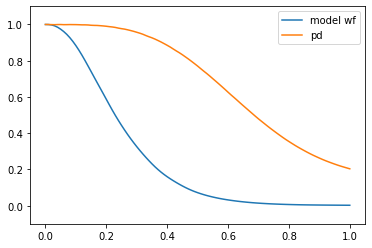

In [64]:
# plt.plot(timespace, Lsi)
l = Lsi.real
c = l <= 1.1
plt.plot(timespace, Lsi, label='model wf')
plt.plot(timespace, Lpd, label='pd')
plt.legend()
plt.ylim(-0.1, 1.1)
# f, p = newt2_fit(timespace, Lsi, r=6)
# plt.plot(timespace[c], f(timespace[c], *p))
# print(p)

In [5]:
llist = []
B = np.array([5000, 0, 0])

for r_dipole in (8, 10):
    calc = pc.Simulator(1/2, vc, [1,0], [0, 1], bath_spins=atoms, 
                        r_bath=r_bath, r_dipole=r_dipole, order=order)
    llist.append(calc.compute_coherence(timespace, B, N, as_delay=False))

NameError: name 'r_bath' is not defined

[0.92785 2.56294]


/home/onizhuk/codes_development/useful_scripts/dmscripts.py:179: RuntimeWarning: invalid value encountered in power
  return np.exp(-(t / t2) ** n) * y[0]
/home/onizhuk/codes_development/useful_scripts/dmscripts.py:179: RuntimeWarning: invalid value encountered in power
  return np.exp(-(t / t2) ** n) * y[0]


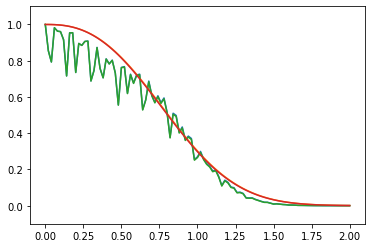

In [157]:
import scipy.optimize
for l in llist:
    l = l.real
    c = l <= 1.1
    plt.plot(timespace[c], l[c])
    plt.ylim(-0.1, 1.1)
    f, p = newt2_fit(timespace[c], l[c], r=6)
    plt.plot(timespace[c], f(timespace[c], *p))
print(p)

In [80]:
sic_ase = ase.io.read('4h-sic_conventional.cif')
sic = pc.bath.NSpinCell.from_ase_Atoms(sic_ase)
sic.add_isotopes(('29Si', 1), ('13C', 1))
atoms = si.gen_supercell(10)

In [90]:
volume = np.linalg.det(sic.cell.T)
print(sic.cell)
print(sic.atoms['Si'].__len__()/volume)

83.96315758938724

[[ 3.09401 -1.547    0.     ]
 [ 0.       2.67949  0.     ]
 [ 0.       0.      10.12782]]
0.04763994250384875


True
True


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


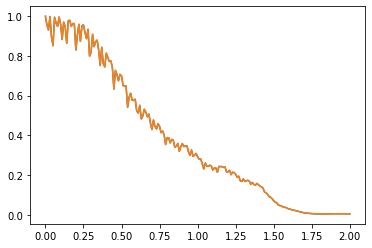

In [30]:
import numpy as np

ts = np.linspace(0, 2, 201)

lp = np.load(f'Z:/codes_development/pyCCE/testing/parallel.npy', allow_pickle=True)
l = np.load(f'Z:/codes_development/pyCCE/testing/single.npy', allow_pickle=True)

dlp = np.load(f'Z:/codes_development/pyCCE/testing/dparallel.npy', allow_pickle=True)
dl = np.load(f'Z:/codes_development/pyCCE/testing/dsingle.npy', allow_pickle=True)

print(np.isclose(l,lp).all())
print(np.isclose(dlp,lp).all())
plt.plot(ts, l)
plt.plot(ts, lp)
